<a href="https://colab.research.google.com/github/casjunior93/projeto-integrador-iv/blob/master/Etl_e_cria%C3%A7%C3%A3o_de_Modelos_com_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas fundamentais

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import scipy.stats as stats
import urllib.request, json 
from pandas.io.json import json_normalize
import pickle
import os
import shutil

#Scikit-Learn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Configura o pandas para não exibir resultados em notação científica
pd.options.display.float_format = '{:.2f}'.format

#Semente aleatória do Numpy
np.random.seed(42)

#Data local
import locale
# Colab não suporta
#locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

if os.path.isdir('assets'):
  pass
else:
  os.mkdir('assets')

# URL base da api de dados

In [2]:
url_base = 'https://univesp-analytics.vercel.app/api/get'

# Lendo Json com Pandas

In [3]:
%%time
pagina = 1
limite = 10000
fim_iteracao_api = False
df_dados_api_original = pd.DataFrame([])

print(f'Início das requisições')
while fim_iteracao_api == False:
  with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:
    data = json.loads(url.read().decode())
    df = pd.DataFrame(json_normalize(data))
    print('.', end='')
    if len(data) == 0:
      print('')
      print(f'Fim. Total de {pagina - 1} páginas e {df_dados_api_original.shape[0]} registros.')
      fim_iteracao_api = True
    else:
      if pagina % 100 == 0:
        print(f'Fim leitura página {pagina}')
      pagina += 1
      df_dados_api_original = pd.concat([df_dados_api_original, df], ignore_index = True)

Início das requisições
...........
Fim. Total de 10 páginas e 93597 registros.
CPU times: user 2.2 s, sys: 166 ms, total: 2.37 s
Wall time: 30.2 s


In [4]:
%%time
''' with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:
    data = json.loads(url.read().decode())
    df_dados_api_original = pd.DataFrame(json_normalize(data)) '''

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.01 µs


" with urllib.request.urlopen(url_base + '?page=' + str(pagina) + '&limite=' + str(limite)) as url:\n    data = json.loads(url.read().decode())\n    df_dados_api_original = pd.DataFrame(json_normalize(data)) "

Cópia dos dados da api

In [5]:
df_dados_api = df_dados_api_original.copy()

Dimensão dos dados - Linhas, colunas

In [6]:
df_dados_api.shape

(93597, 9)

# Visualizando dados originais

Mudando ordenação dos dados

In [7]:
df_dados_api.sort_index(ascending=False, inplace=True, ignore_index=True)

Cinco primeiros registros do dataframe - Em ordem da disposição na API

In [8]:
df_dados_api.head()

,_id,temp_ar,umid_ar,type,local,time.time_js,time.data,time.hora,teste
0,63fea0720dd58484fc266c80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.00
1,63ffdbb91a4eb0dfdd6a11a7,2,3,teste,NaN,2023-03-01T23:11:53.036Z,01/03/2023,20:11:53,NaN
2,63ffdbde1a4eb0dfdd6a11a8,10,10,teste,NaN,2023-03-01T23:12:30.063Z,01/03/2023,20:12:30,NaN
3,63ffdea6722bef68acc5bb72,333,333,teste,NaN,2023-03-01T23:24:21.438Z,01/03/2023,23:24:21,NaN
4,63ffed2b38c8784e07b788f2,15,15,teste,NaN,01/03/2023 21:26:19,01/03/2023,21:26:19,NaN


Cinco últimos registros do dataframe

In [9]:
df_dados_api.tail()

,_id,temp_ar,umid_ar,type,local,time.time_js,time.data,time.hora,teste
93592,646de901482c9dc242bbc5d7,22.20,53.40,teste,comAr,"24/05/2023, 07:37:53","24/05/2023,",07:37:53,NaN
93593,646de995482c9dc242bbc5d8,18.50,66.40,teste,semAr,"24/05/2023, 07:40:21","24/05/2023,",07:40:21,NaN
93594,646dea2f482c9dc242bbc5d9,22.20,53.40,teste,comAr,"24/05/2023, 07:42:55","24/05/2023,",07:42:55,NaN
93595,646deac4482c9dc242bbc5da,18.60,66.30,teste,semAr,"24/05/2023, 07:45:24","24/05/2023,",07:45:24,NaN
93596,646deb5e482c9dc242bbc5db,22.00,52.70,teste,comAr,"24/05/2023, 07:47:58","24/05/2023,",07:47:58,NaN


Verificando dados nulos

In [10]:
df_dados_api.isnull().sum()

_id                 0
temp_ar             3
umid_ar             3
type                1
local           55412
time.time_js        1
time.data           1
time.hora           1
teste           93596
dtype: int64

Excluindo colunas desnecessárias

In [11]:
del df_dados_api['teste']
del df_dados_api['_id']
del df_dados_api['type']
del df_dados_api['time.time_js']
df_dados_api.head()

,temp_ar,umid_ar,local,time.data,time.hora
0,NaN,NaN,NaN,NaN,NaN
1,2,3,NaN,01/03/2023,20:11:53
2,10,10,NaN,01/03/2023,20:12:30
3,333,333,NaN,01/03/2023,23:24:21
4,15,15,NaN,01/03/2023,21:26:19


Tratando nova coluna local

In [12]:
df_dados_api.local.value_counts()

semAr    27643
comAr    10538
API          2
teste        1
123          1
Name: local, dtype: int64

In [13]:
values = {"local": "comAr"}
df_dados_api.fillna(value=values, inplace=True)

In [14]:
df_dados_api.local.value_counts()

comAr    65950
semAr    27643
API          2
teste        1
123          1
Name: local, dtype: int64

Limpeza de dados nulos

In [15]:
df_dados_api.dropna(inplace = True)
df_dados_api.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
dtype: int64

Removendo dados duplicados

In [16]:
df_dados_api.shape

(93594, 5)

In [17]:
df_dados_api.drop_duplicates(inplace=True, ignore_index=True)
df_dados_api.shape

(93594, 5)

# Comportamento das variáveis

Tipo dos dados e convertendo strings para float

In [18]:
df_dados_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93594 entries, 0 to 93593
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   temp_ar    93594 non-null  object
 1   umid_ar    93594 non-null  object
 2   local      93594 non-null  object
 3   time.data  93594 non-null  object
 4   time.hora  93594 non-null  object
dtypes: object(5)
memory usage: 3.6+ MB


In [19]:
df_dados_api = df_dados_api.astype({'temp_ar':'float', 'umid_ar':'float'})
df_dados_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93594 entries, 0 to 93593
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp_ar    93594 non-null  float64
 1   umid_ar    93594 non-null  float64
 2   local      93594 non-null  object 
 3   time.data  93594 non-null  object 
 4   time.hora  93594 non-null  object 
dtypes: float64(2), object(3)
memory usage: 3.6+ MB


Análise descritiva dos dados

In [20]:
df_dados_api.describe()

,temp_ar,umid_ar
count,93594.00,93594.00
mean,25.26,59.29
std,2.74,8.28
min,2.00,3.00
25%,24.40,54.00
50%,25.90,57.40
75%,26.40,63.60
max,333.00,333.00


Opa, parece haver outliers.

Separando os conjuntos de dados do ambiente com ar condicionado e sem ar condicionado.

In [21]:
df_comAr = df_dados_api.loc[df_dados_api['local'] == 'comAr']
df_semAr = df_dados_api.loc[df_dados_api['local'] == 'semAr']

Verificando outliers

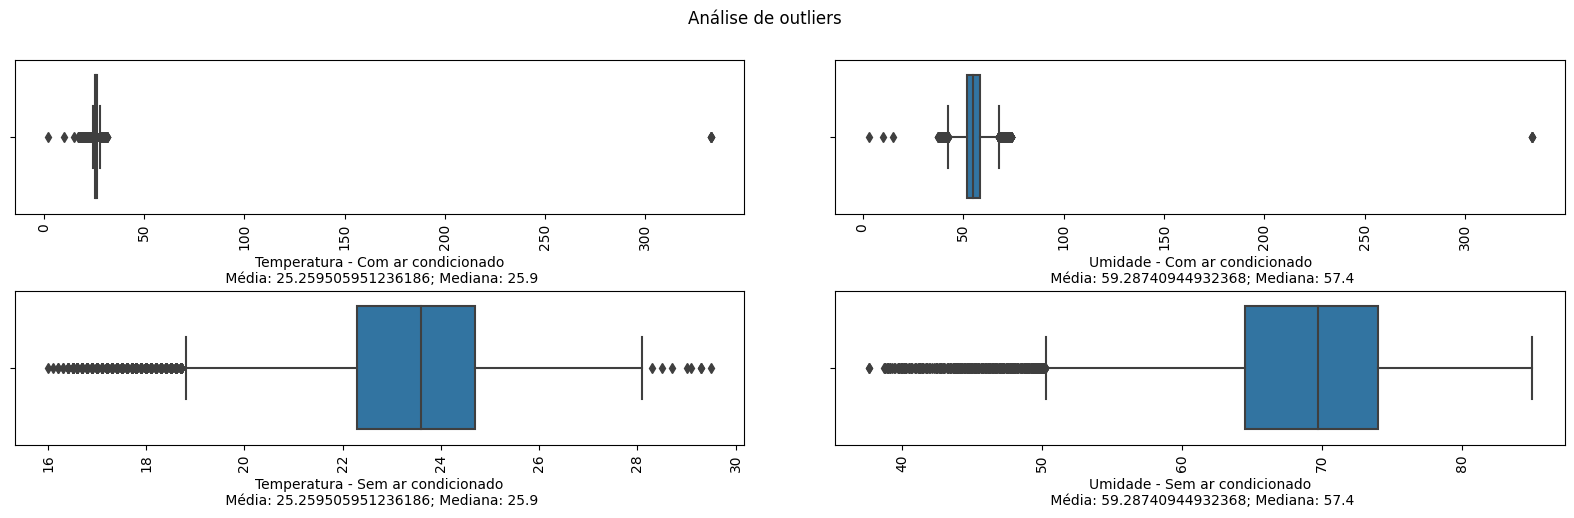

CPU times: user 748 ms, sys: 120 ms, total: 867 ms
Wall time: 827 ms


In [22]:
%%time
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Análise de outliers')

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura - Com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade - Com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura - Sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade - Sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Excluindo outliers superiores do conjunto com ar condicionado

In [23]:
def limites_outliers(coluna):
  Q1 = coluna.quantile(.25)
  Q3 = coluna.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  return limite_inferior, limite_superior

In [24]:
limite_inferior_temp_ar, limite_superior_temp_ar = limites_outliers(df_comAr['temp_ar'])
limite_inferior_umid_ar, limite_superior_umid_ar = limites_outliers(df_comAr['umid_ar'])

Visualizando registros considerados como outliers

In [25]:
selecao_temp_ar = (df_comAr['temp_ar'] > limite_superior_temp_ar) | (df_comAr['umid_ar'] > limite_superior_umid_ar)
temp_ar1 = df_comAr[selecao_temp_ar]
temp_ar1.describe()

,temp_ar,umid_ar
count,2184.00,2184.00
mean,28.14,54.82
std,13.16,14.81
min,21.90,43.00
25%,28.00,48.00
50%,28.20,51.00
75%,28.40,55.00
max,333.00,333.00


In [26]:
selecao_temp_ar2 = (temp_ar1['temp_ar'] < 333.0) | (temp_ar1['umid_ar'] < 333.0)
temp_ar2 = temp_ar1[selecao_temp_ar2]
temp_ar2.describe()

,temp_ar,umid_ar
count,2180.00,2180.00
mean,27.58,54.30
std,1.58,8.79
min,21.90,43.00
25%,28.00,48.00
50%,28.20,51.00
75%,28.40,55.00
max,31.20,74.00


Removendo dados com valor de temp_ar e umid_ar iguais à 333,0. Não vou remover valores menores que este porque são valores possíveis de acontecer.

In [27]:
selecao_temp_ar = (df_comAr['temp_ar'] <= 31.20) & (df_comAr['umid_ar'] <= 74)
df_comAr = df_comAr[selecao_temp_ar]

Revendo boxplots

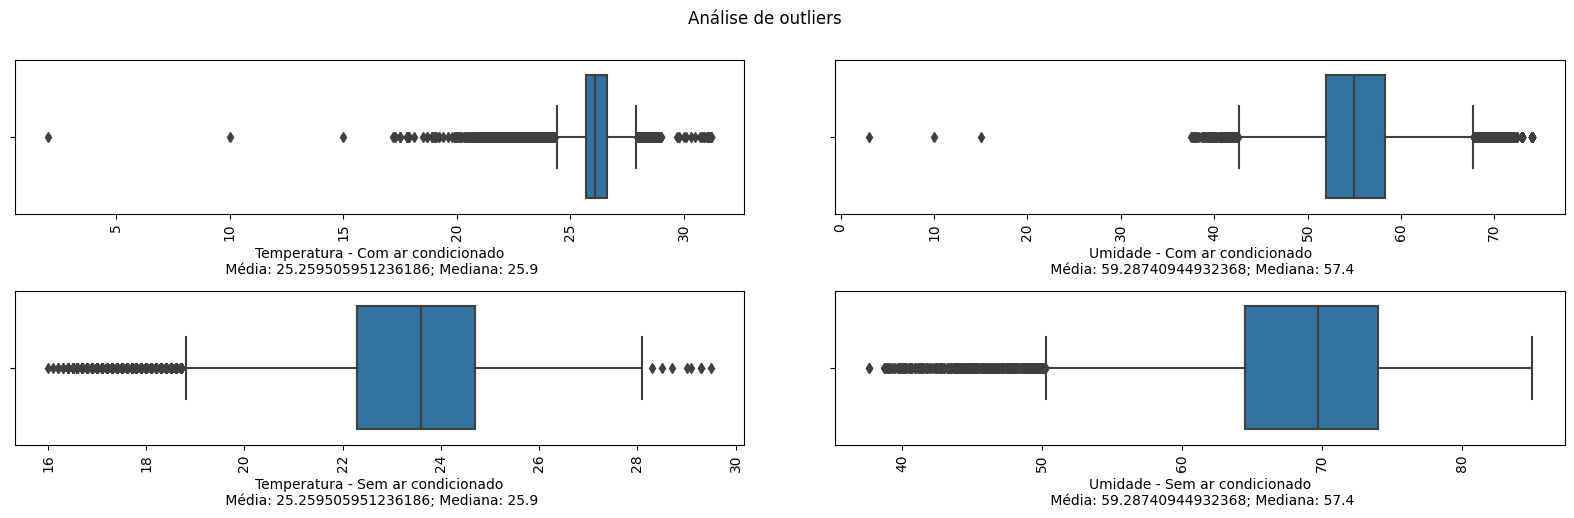

In [28]:
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Análise de outliers')

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura - Com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade - Com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura - Sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade Com ar condicionado - Boxplot
sns.boxplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade - Sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Agora as curvas de densidade das variáveis

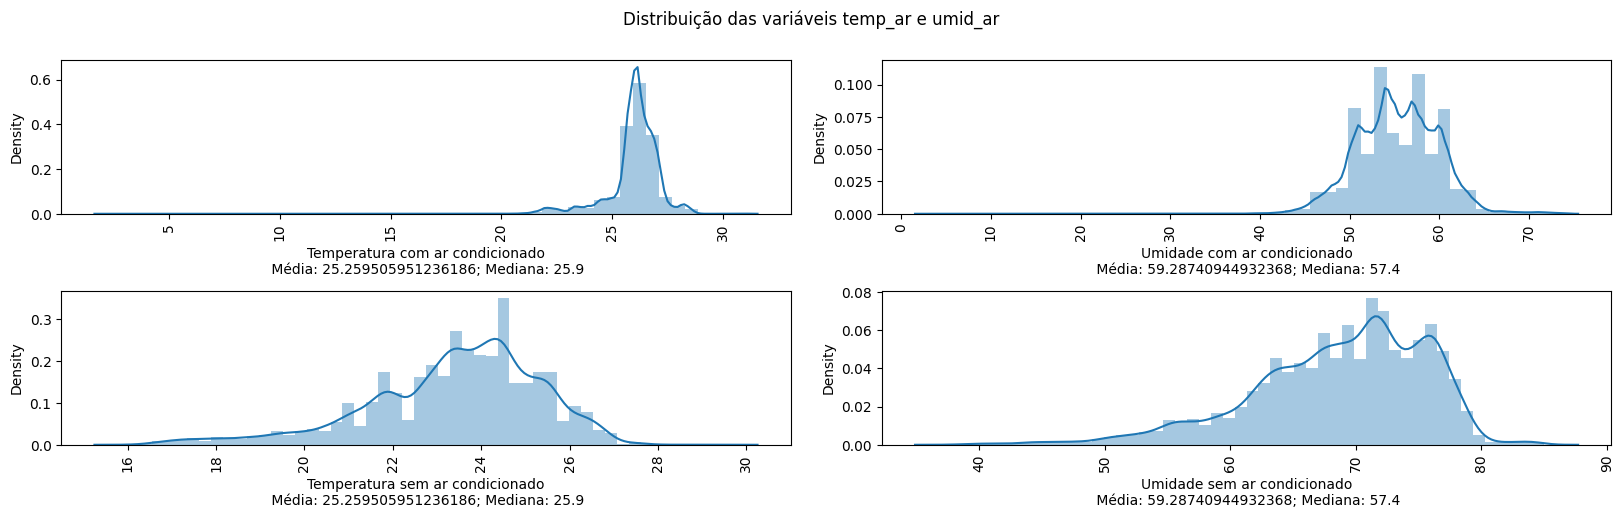

CPU times: user 2.57 s, sys: 396 ms, total: 2.96 s
Wall time: 2.71 s


In [29]:
%%time
fig, axes = plt.subplots(2, 2, figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('Distribuição das variáveis temp_ar e umid_ar')

#Temperatura - distplot
sns.distplot(ax=axes[0,0],x=df_comAr['temp_ar'])
axes[0,0].tick_params(axis='x', rotation=90)
axes[0,0].set(xlabel='Temperatura com ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade - distplot
sns.distplot(ax=axes[0,1],x=df_comAr['umid_ar'])
axes[0,1].tick_params(axis='x', rotation=90)
axes[0,1].set(xlabel='Umidade com ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

#Temperatura - distplot
sns.distplot(ax=axes[1,0],x=df_semAr['temp_ar'])
axes[1,0].tick_params(axis='x', rotation=90)
axes[1,0].set(xlabel='Temperatura sem ar condicionado\n Média: ' + str(df_dados_api['temp_ar'].mean()) + '; Mediana: ' + str(df_dados_api['temp_ar'].median()))

#Umidade - distplot
sns.distplot(ax=axes[1,1],x=df_semAr['umid_ar'])
axes[1,1].tick_params(axis='x', rotation=90)
axes[1,1].set(xlabel='Umidade sem ar condicionado\n Média: ' + str(df_dados_api['umid_ar'].mean()) + '; Mediana: ' + str(df_dados_api['umid_ar'].median()))

plt.show();

Testando se as distruições são normais

In [30]:
%%time
stat_temp_comar,p_temp_comarar = stats.shapiro(df_comAr['temp_ar'].to_numpy())
stat_umid_comarar,p_umid_comarar = stats.shapiro(df_comAr['umid_ar'].to_numpy())

stat_temp_semar,p_temp_semar = stats.shapiro(df_semAr['temp_ar'].to_numpy())
stat_umid_semar,p_umid_semar = stats.shapiro(df_semAr['umid_ar'].to_numpy())

CPU times: user 15.6 ms, sys: 77 µs, total: 15.7 ms
Wall time: 21.2 ms


In [31]:
print(f'p-value temp_ar com ar condicionado: {p_temp_comarar:.5f}')
print(f'p-value umid_ar com ar condicionado: {p_umid_comarar:.5f}')
print(f'p-value temp_ar sem ar condicionado: {p_temp_semar:.5f}')
print(f'p-value umid_ar sem ar condicionado: {p_umid_semar:.5f}')

p-value temp_ar com ar condicionado: 0.00000
p-value umid_ar com ar condicionado: 0.00000
p-value temp_ar sem ar condicionado: 0.00000
p-value umid_ar sem ar condicionado: 0.00000


Com os p_values < 0.5, logo curvas não normais.

# Tratando data

Copiando dataframes para uma nova variável

In [32]:
dados_projeto_comar = df_comAr.copy()
dados_projeto_semar = df_semAr.copy()

Removendo virgula de time.data e concatenando com time.hora para gerar data no formato datetime

In [33]:
def converte_data_portugues_para_ingles(df):
  return datetime.strptime(df['time.data'], "%d/%m/%Y").strftime("%Y-%m-%d");

In [34]:
dados_projeto_comar['time.data'] = dados_projeto_comar['time.data'].str.replace(',','')
dados_projeto_comar['time.data'] = dados_projeto_comar.apply(lambda x: converte_data_portugues_para_ingles(x), axis=1)
dados_projeto_comar['data'] = dados_projeto_comar['time.data'] + ' ' + dados_projeto_comar['time.hora']
dados_projeto_comar['data'] = dados_projeto_comar['data'].astype('datetime64[ns]')

dados_projeto_semar['time.data'] = dados_projeto_semar['time.data'].str.replace(',','')
dados_projeto_semar['time.data'] = dados_projeto_semar.apply(lambda x: converte_data_portugues_para_ingles(x), axis=1)
dados_projeto_semar['data'] = dados_projeto_semar['time.data'] + ' ' + dados_projeto_semar['time.hora']
dados_projeto_semar['data'] = dados_projeto_semar['data'].astype('datetime64[ns]')

In [35]:
dados_projeto_semar.tail()

,temp_ar,umid_ar,local,time.data,time.hora,data
93584,18.70,65.40,semAr,2023-05-24,07:25:15,2023-05-24 07:25:15
93586,18.60,65.70,semAr,2023-05-24,07:30:17,2023-05-24 07:30:17
93588,18.50,66.30,semAr,2023-05-24,07:35:19,2023-05-24 07:35:19
93590,18.50,66.40,semAr,2023-05-24,07:40:21,2023-05-24 07:40:21
93592,18.60,66.30,semAr,2023-05-24,07:45:24,2023-05-24 07:45:24


Verificando nulos novamente

In [36]:
dados_projeto_semar.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
data         0
dtype: int64

In [37]:
dados_projeto_comar.isnull().sum()

temp_ar      0
umid_ar      0
local        0
time.data    0
time.hora    0
data         0
dtype: int64

Deletando colunas que não vamos usar mais

In [38]:
del dados_projeto_semar['time.data']
del dados_projeto_semar['time.hora']
del dados_projeto_semar['local']

del dados_projeto_comar['time.data']
del dados_projeto_comar['time.hora']
del dados_projeto_comar['local']

# Filtro por período a partir do dia 04/03/2023

In [39]:
filtro = (dados_projeto_comar.data >= '2023-03-04 00:00:00')
serie_comar = dados_projeto_comar.loc[filtro]
serie_comar.head()

,temp_ar,umid_ar,data
504,26.60,57.00,2023-03-04 00:04:12
505,26.60,58.00,2023-03-04 00:09:14
506,26.60,57.00,2023-03-04 00:14:16
507,26.60,57.00,2023-03-04 00:19:18
508,26.60,57.00,2023-03-04 00:24:21


In [40]:
filtro2 = (dados_projeto_semar.data >= '2023-03-04 00:00:00')
serie_semar = dados_projeto_semar.loc[filtro2]
serie_semar.head()

,temp_ar,umid_ar,data
29347,29.10,60.50,2023-04-04 15:00:43
29350,29.50,62.30,2023-04-04 15:01:46
29354,29.30,59.10,2023-04-04 15:03:43
29356,29.30,59.00,2023-04-04 15:04:45
29359,29.00,58.50,2023-04-04 15:05:47


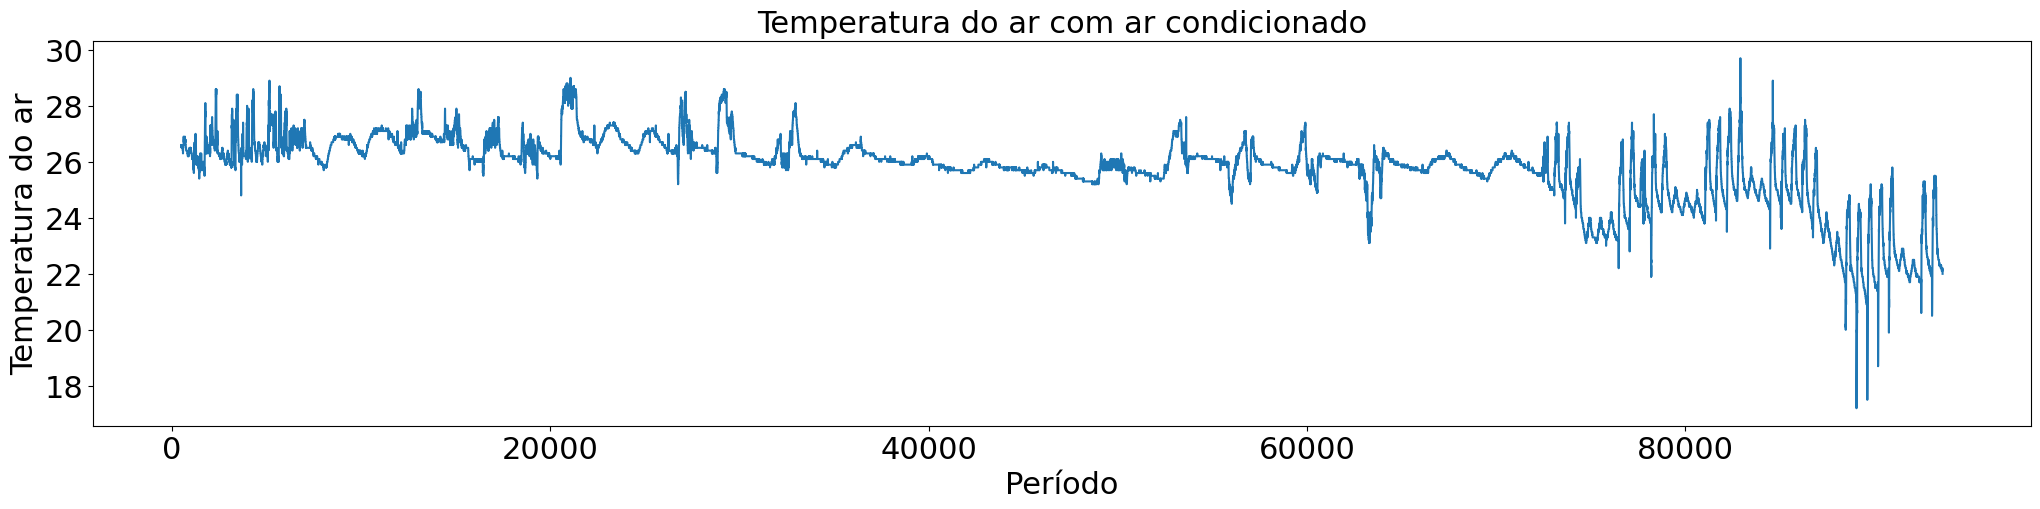

CPU times: user 554 ms, sys: 116 ms, total: 669 ms
Wall time: 553 ms


In [41]:
%%time
plt.figure(figsize=(25,5))
serie_comar.temp_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Temperatura do ar com ar condicionado',size=22)

plt.savefig('assets/data_temp_ar_conjunto_tratado_original.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

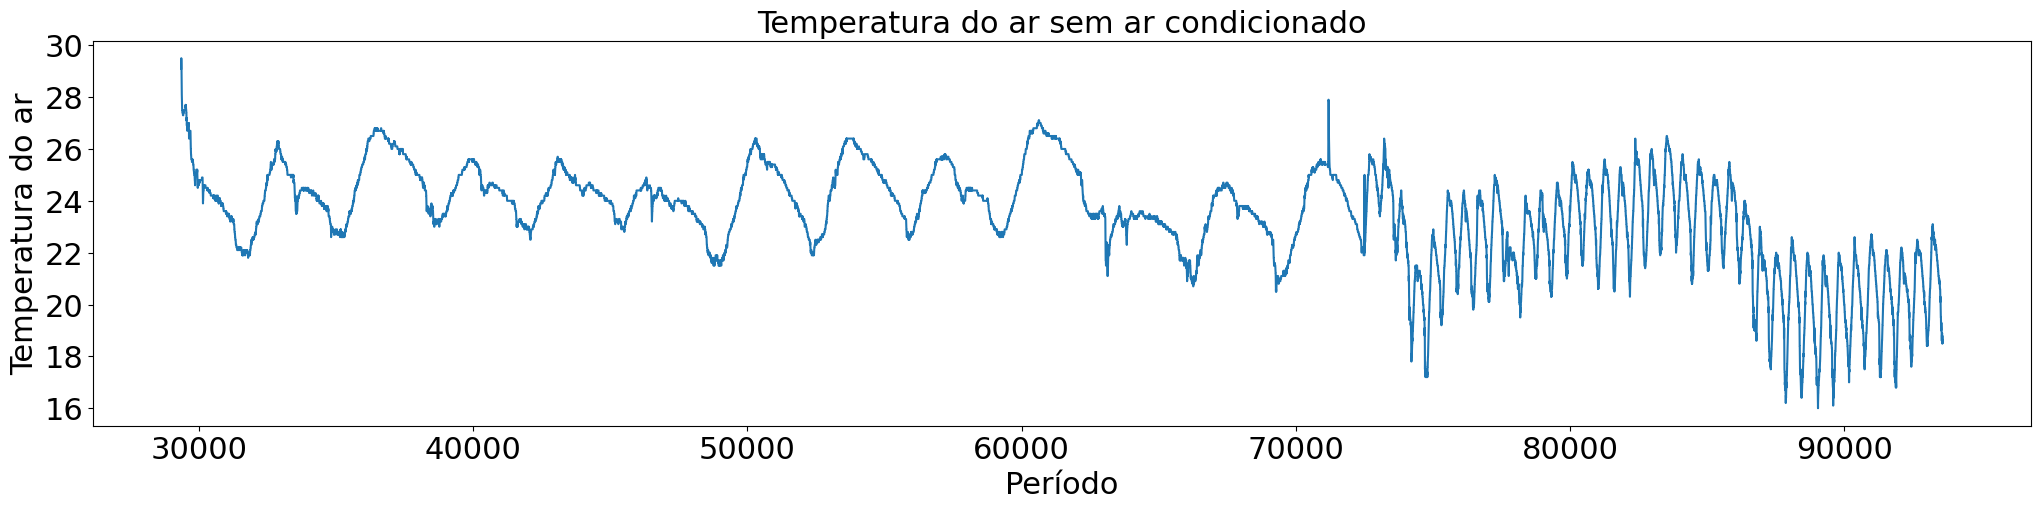

CPU times: user 566 ms, sys: 83.7 ms, total: 650 ms
Wall time: 576 ms


In [42]:
%%time
plt.figure(figsize=(25,5))
serie_semar.temp_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Temperatura do ar sem ar condicionado',size=22)

plt.savefig('assets/data_temp_ar_conjunto_tratado_original_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

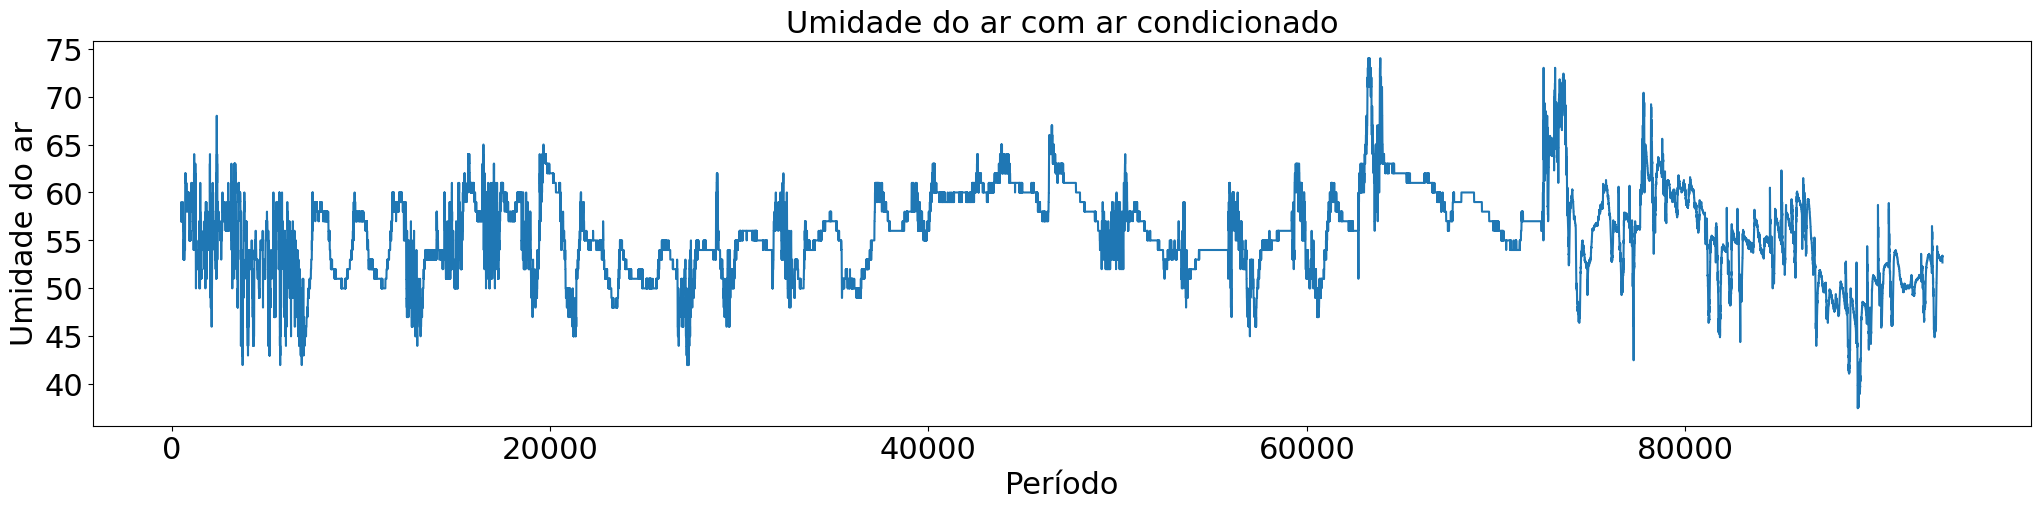

CPU times: user 620 ms, sys: 121 ms, total: 741 ms
Wall time: 644 ms


In [43]:
%%time
plt.figure(figsize=(25,5))
serie_comar.umid_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Umidade do ar com ar condicionado',size=22)

plt.savefig('assets/data_umidade_ar_conjunto_tratado_original.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

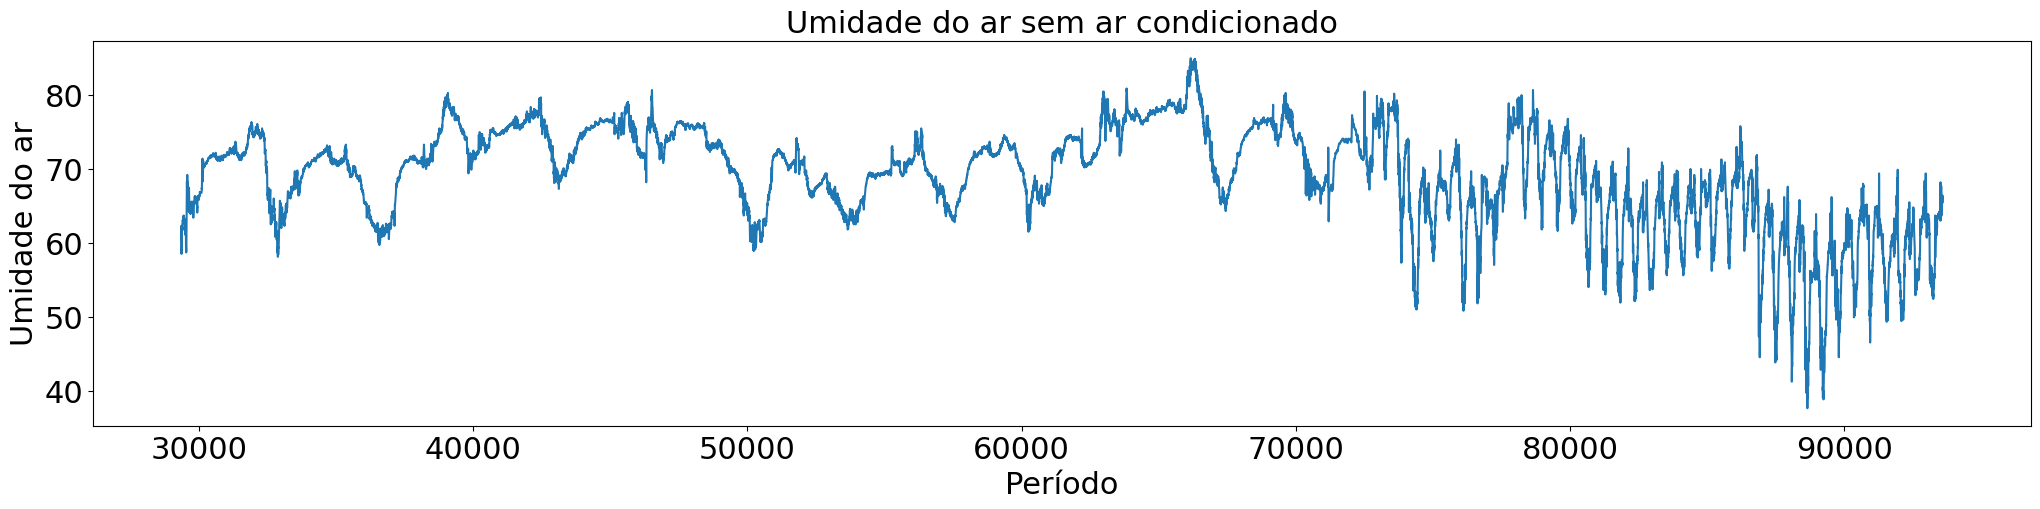

CPU times: user 582 ms, sys: 127 ms, total: 708 ms
Wall time: 602 ms


In [44]:
%%time
plt.figure(figsize=(25,5))
serie_semar.umid_ar.plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Período',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Umidade do ar sem ar condicionado',size=22)

plt.savefig('assets/data_umidade_ar_conjunto_tratado_original_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

# Agrupando dados a cada t minuto(s) utilizando a média

Vamos tentar reduzir o ruído.

Definindo os minutos

In [45]:
minutos = 60

Setando a data como index

In [46]:
serie_comar.set_index('data', inplace=True)
serie_semar.set_index('data', inplace=True)

In [47]:
serie_comar.head(2)

,temp_ar,umid_ar
data,,
2023-03-04 00:04:12,26.60,57.00
2023-03-04 00:09:14,26.60,58.00


Agrupando os valores de data para cada t minuto(s) pela média

In [48]:
%%time
dados_agrupados_minutos_comar = serie_comar.resample(str(minutos) + 'T').mean()
dados_agrupados_minutos_comar.head(2)

CPU times: user 13.1 ms, sys: 1.91 ms, total: 15 ms
Wall time: 27.6 ms


,temp_ar,umid_ar
data,,
2023-03-04 00:00:00,26.60,57.58
2023-03-04 01:00:00,26.59,57.82


In [49]:
%%time
dados_agrupados_minutos_semar = serie_semar.resample(str(minutos) + 'T').mean()
dados_agrupados_minutos_semar.head(2)

CPU times: user 6.58 ms, sys: 950 µs, total: 7.53 ms
Wall time: 9.05 ms


,temp_ar,umid_ar
data,,
2023-04-04 15:00:00,27.68,62.30
2023-04-04 16:00:00,27.14,64.92


Tamanho do conjunto gerado

In [50]:
dados_agrupados_minutos_comar.shape

(1952, 2)

In [51]:
dados_agrupados_minutos_semar.shape

(1193, 2)

Verificando nulos

In [52]:
dados_agrupados_minutos_comar.isnull().sum()

temp_ar    5
umid_ar    5
dtype: int64

In [53]:
dados_agrupados_minutos_semar.isnull().sum()

temp_ar    0
umid_ar    0
dtype: int64

Preenchendo nulos com os valores anteriores

In [54]:
dados_agrupados_minutos_comar.fillna(method="ffill", inplace = True)

Verificando novamente os nulos

In [55]:
dados_agrupados_minutos_comar.isnull().sum()

temp_ar    0
umid_ar    0
dtype: int64

# Gráficos

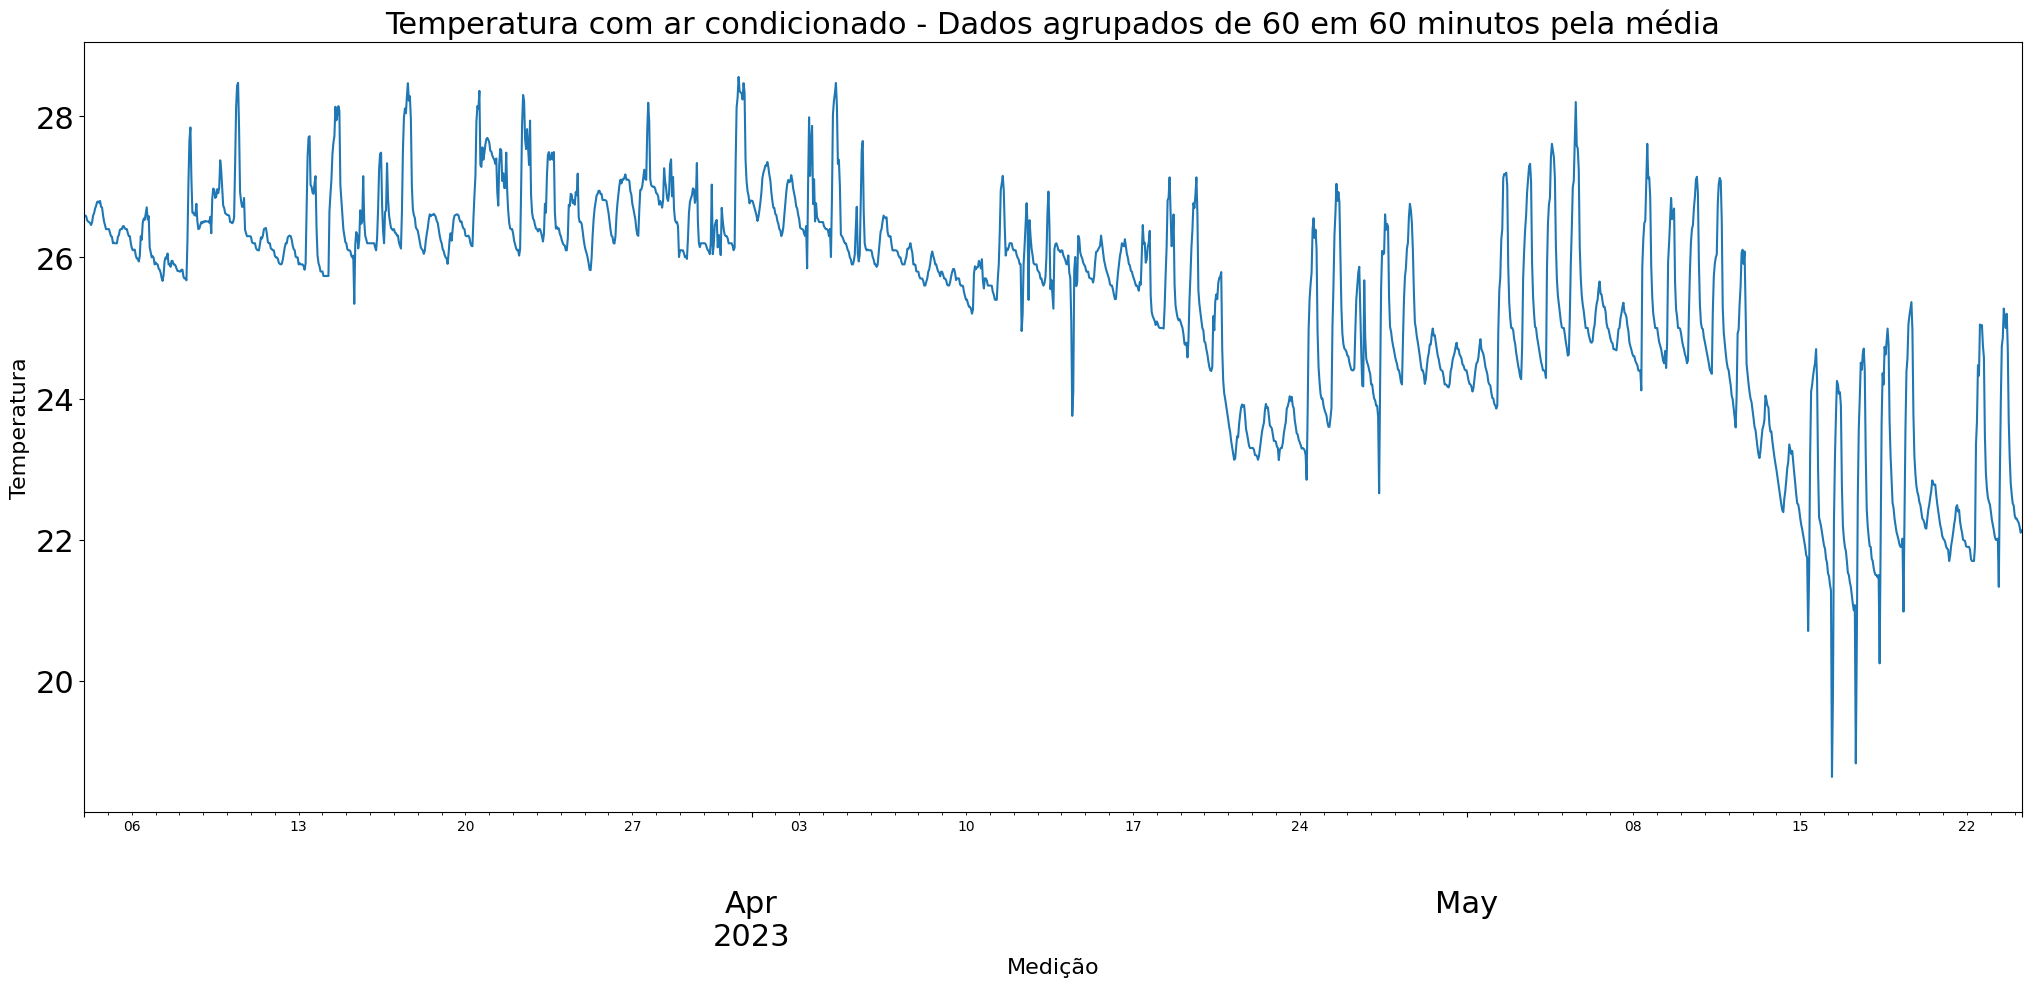

CPU times: user 1.28 s, sys: 114 ms, total: 1.4 s
Wall time: 1.33 s


In [56]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_comar['temp_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=16)
plt.ylabel('Temperatura',size=16)
plt.title(f'Temperatura com ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'assets/data_temperatura_ar_conjunto_dados_agrupados_{minutos}_minutos.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

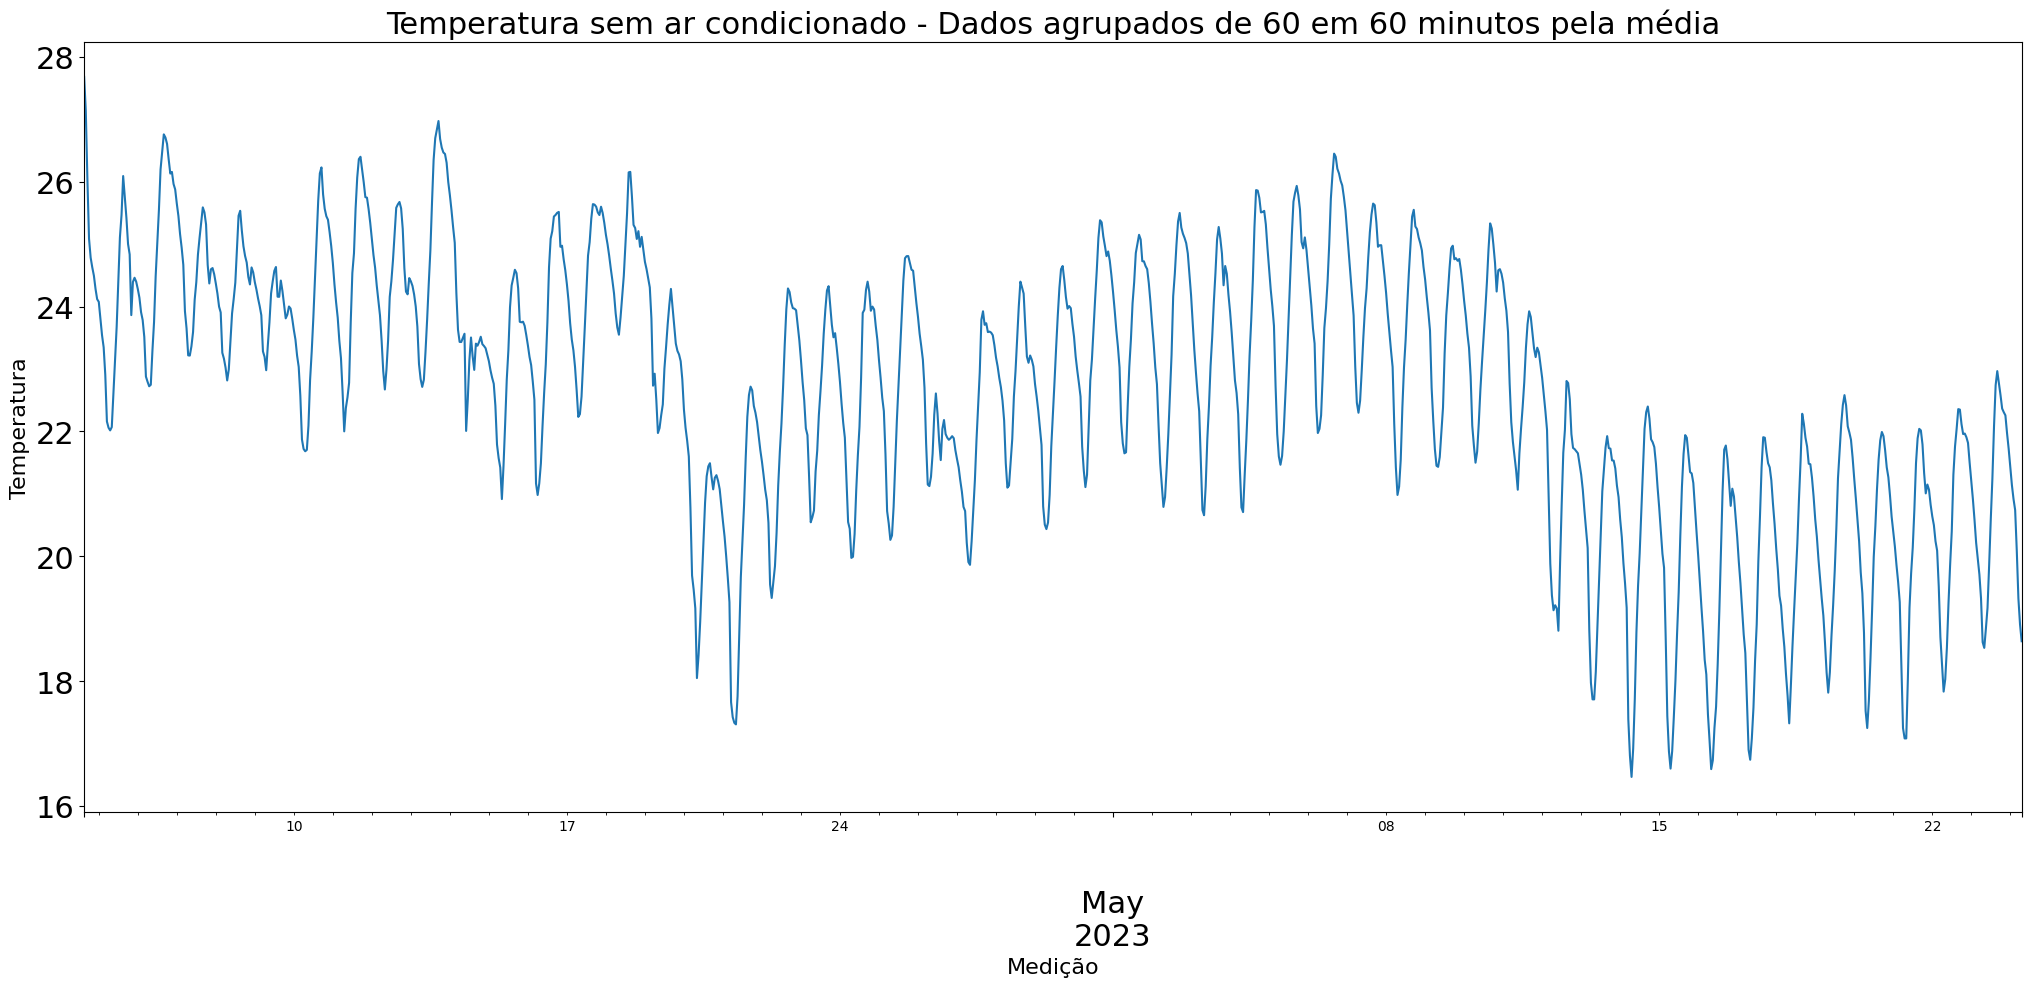

CPU times: user 1 s, sys: 126 ms, total: 1.13 s
Wall time: 1.03 s


In [57]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_semar['temp_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=16)
plt.ylabel('Temperatura',size=16)
plt.title(f'Temperatura sem ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'assets/data_temperatura_ar_conjunto_dados_agrupados_{minutos}_minutos_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

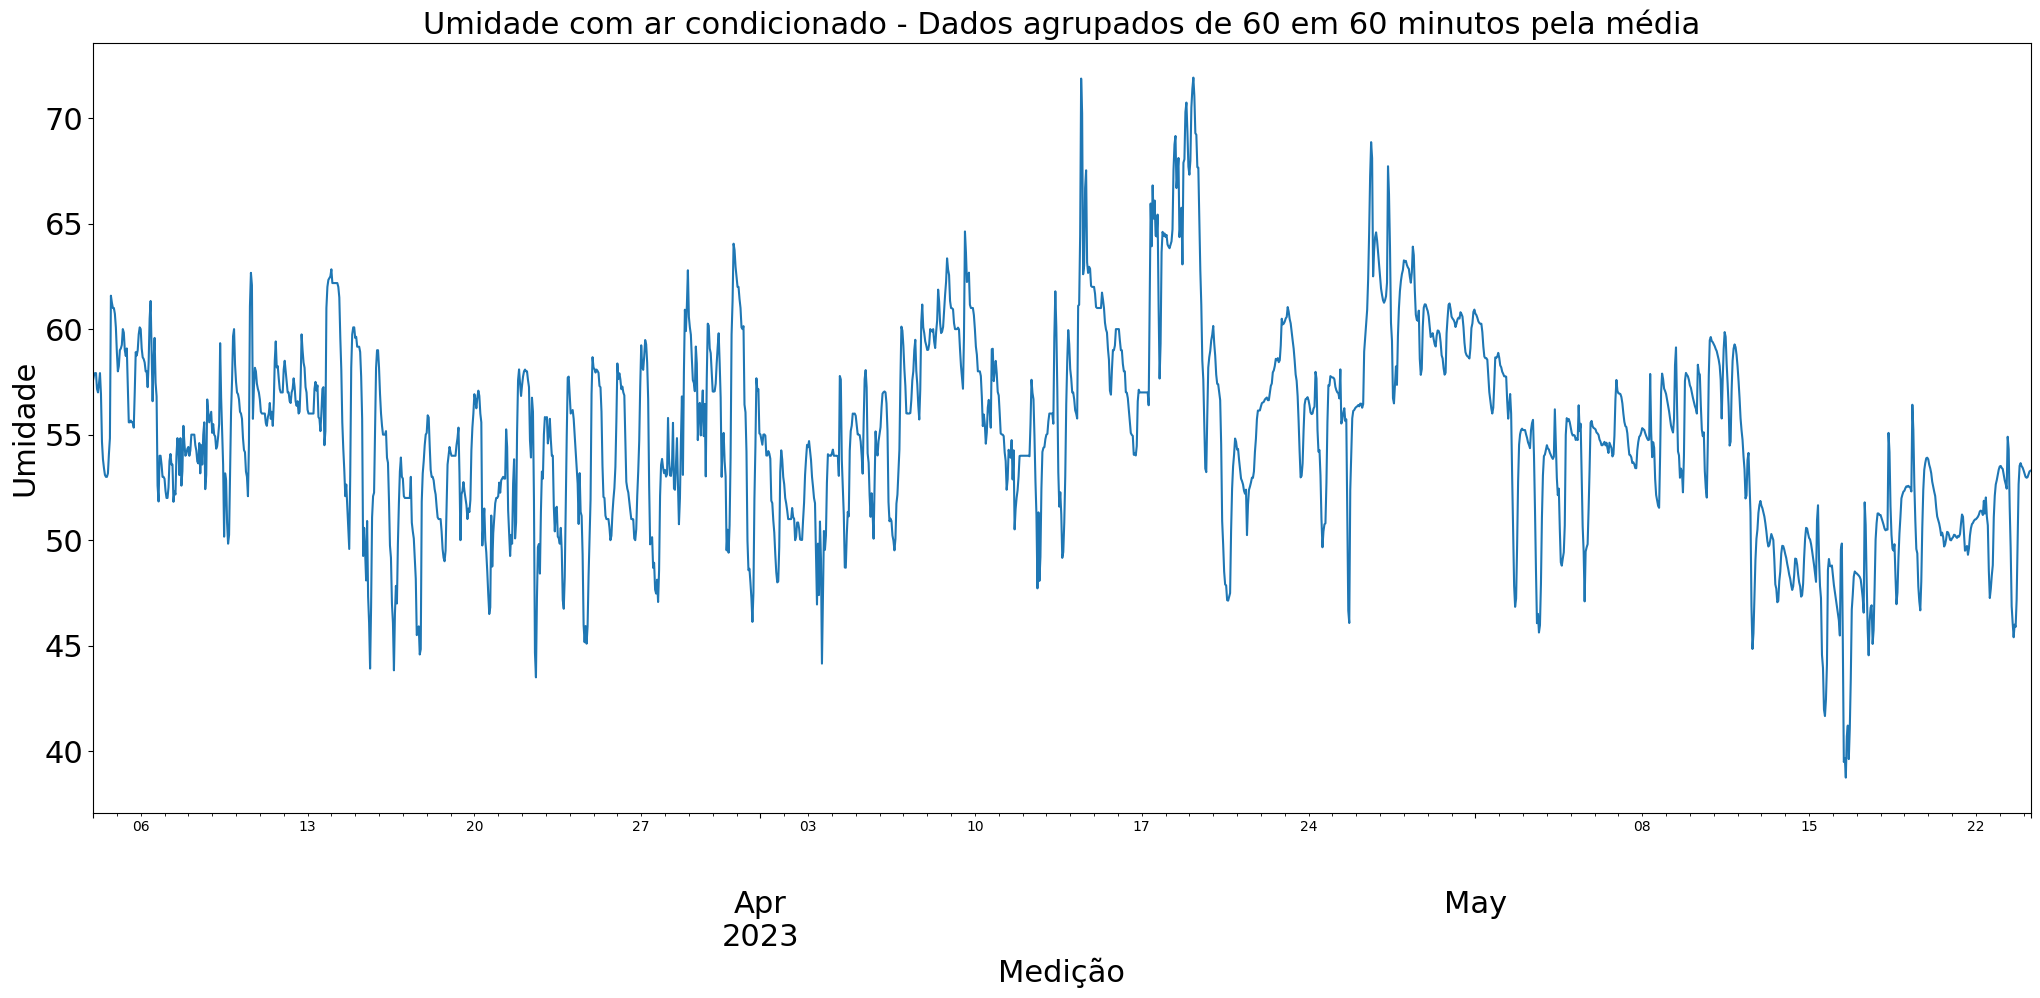

CPU times: user 1.68 s, sys: 118 ms, total: 1.8 s
Wall time: 1.7 s


In [58]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_comar['umid_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=22)
plt.ylabel('Umidade',size=22)
plt.title(f'Umidade com ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'assets/data_umidade_ar_conjunto_dados_agrupados_{minutos}_minutos.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

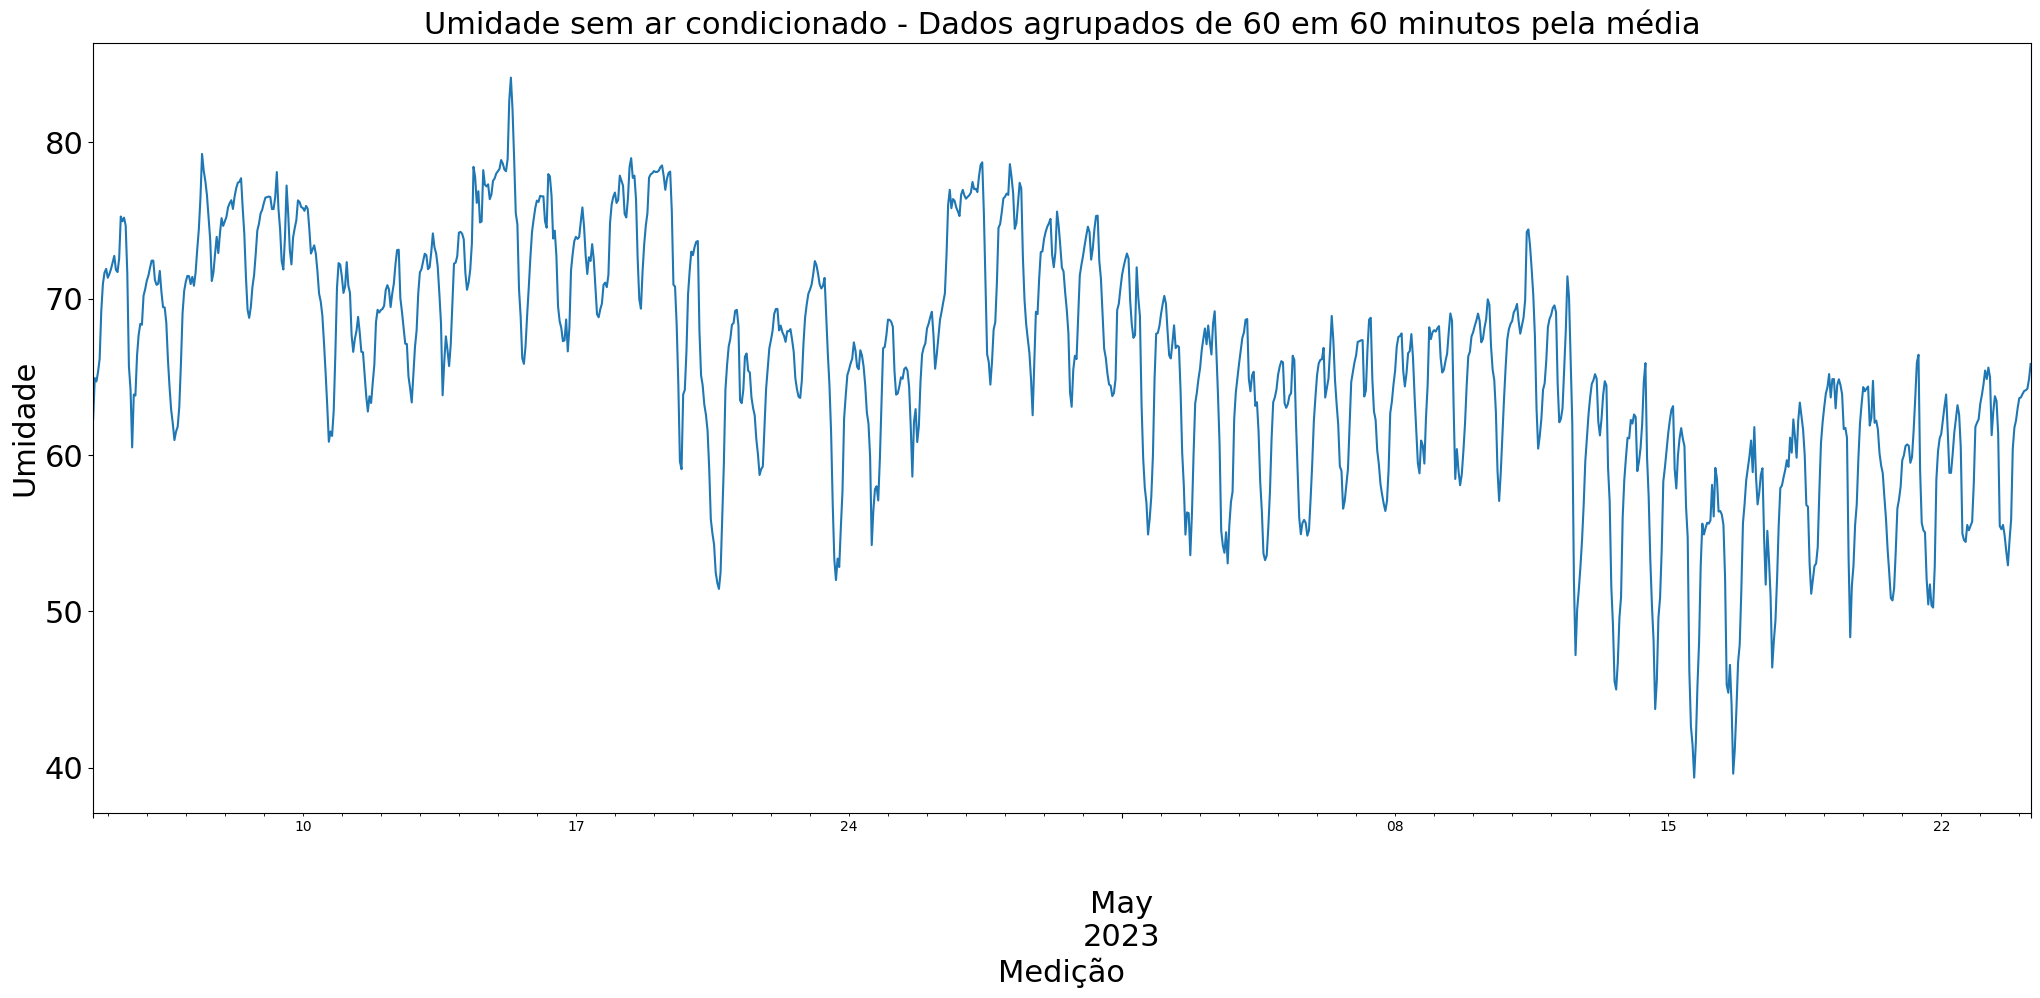

CPU times: user 1.57 s, sys: 81.6 ms, total: 1.65 s
Wall time: 1.75 s


In [59]:
%%time
plt.figure(figsize=(25,10))
dados_agrupados_minutos_semar['umid_ar'].plot()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Medição',size=22)
plt.ylabel('Umidade',size=22)
plt.title(f'Umidade sem ar condicionado - Dados agrupados de {minutos} em {minutos} minutos pela média',size=22)

plt.savefig(f'assets/data_umidade_ar_conjunto_dados_agrupados_{minutos}_minutos_sem_ar.png', facecolor='white', transparent=False)  
plt.show() 
plt.close()

plt.show()

# Suavização com média móvel e rolling

In [60]:
dados_agrupados_minutos_comar_cp = dados_agrupados_minutos_comar.copy()
dados_agrupados_minutos_semar_cp = dados_agrupados_minutos_semar.copy()

In [61]:
''' dados_agrupados_minutos_comar = dados_agrupados_minutos_comar_cp
dados_agrupados_minutos_semar = dados_agrupados_minutos_semar_cp '''

' dados_agrupados_minutos_comar = dados_agrupados_minutos_comar_cp\ndados_agrupados_minutos_semar = dados_agrupados_minutos_semar_cp '

In [62]:
dados_agrupados_minutos_comar['media_24_horas_temp_ar'] = dados_agrupados_minutos_comar.temp_ar.rolling(24).mean()
dados_agrupados_minutos_comar['media_24_horas_umid_ar'] = dados_agrupados_minutos_comar.umid_ar.rolling(24).mean()

dados_agrupados_minutos_semar['media_24_horas_temp_ar'] = dados_agrupados_minutos_semar.temp_ar.rolling(24).mean()
dados_agrupados_minutos_semar['media_24_horas_umid_ar'] = dados_agrupados_minutos_semar.umid_ar.rolling(24).mean()

In [63]:
dados_agrupados_minutos_comar.head(24)

,temp_ar,umid_ar,media_24_horas_temp_ar,media_24_horas_umid_ar
data,,,,
2023-03-04 00:00:00,26.60,57.58,NaN,NaN
2023-03-04 01:00:00,26.59,57.82,NaN,NaN
2023-03-04 02:00:00,26.58,57.92,NaN,NaN
2023-03-04 03:00:00,26.53,57.92,NaN,NaN
2023-03-04 04:00:00,26.51,57.17,NaN,NaN
2023-03-04 05:00:00,26.50,57.00,NaN,NaN
2023-03-04 06:00:00,26.48,57.42,NaN,NaN
2023-03-04 07:00:00,26.46,57.92,NaN,NaN
2023-03-04 08:00:00,26.50,56.92,NaN,NaN


Comparando a média móvel com os dados

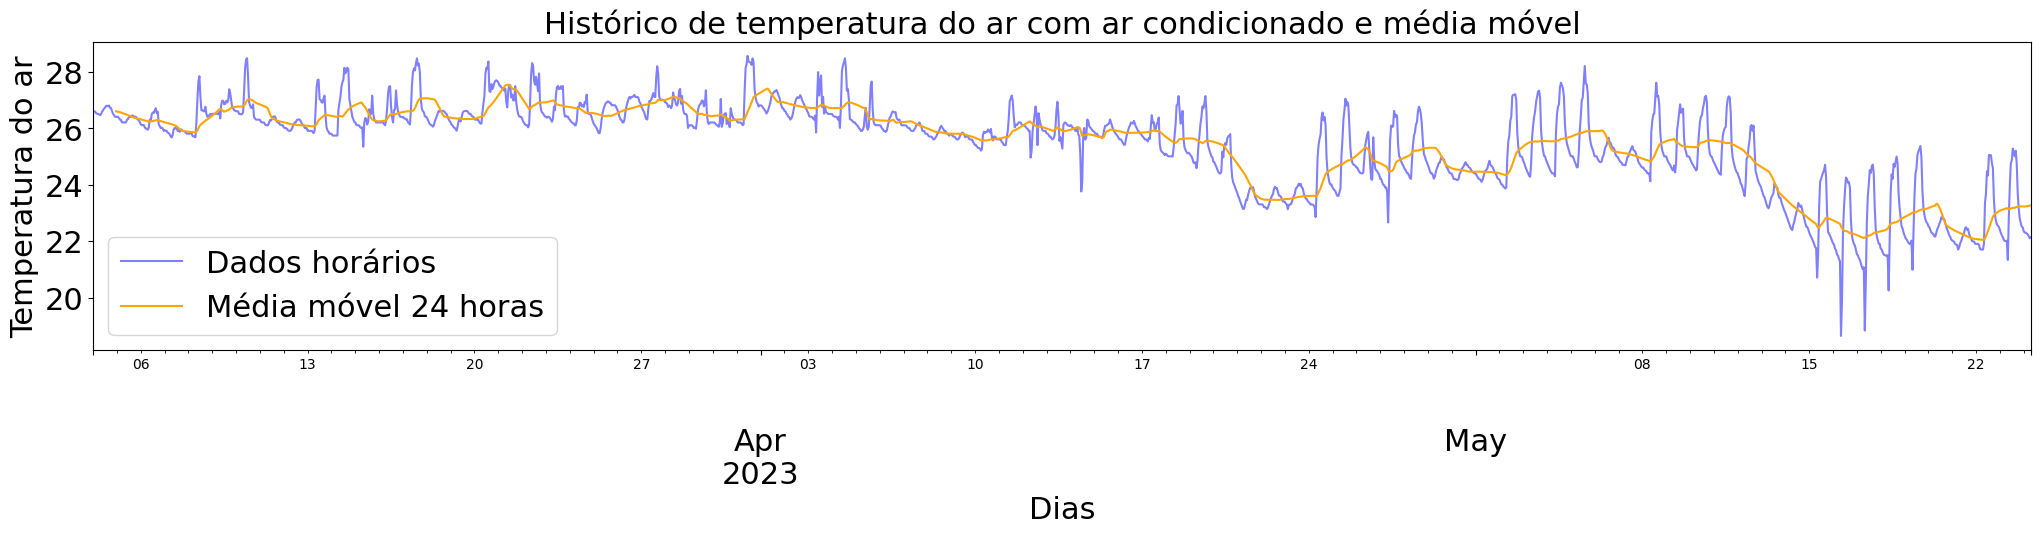

CPU times: user 1.66 s, sys: 81.3 ms, total: 1.74 s
Wall time: 1.81 s


In [64]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_comar.temp_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_comar['media_24_horas_temp_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Histórico de temperatura do ar com ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)

plt.savefig(f'assets/data_temperatura_ar_comar_conjunto_dados_agrupados_{minutos}_minutos_com_media_movel.png', facecolor='white', transparent=False)
plt.show()

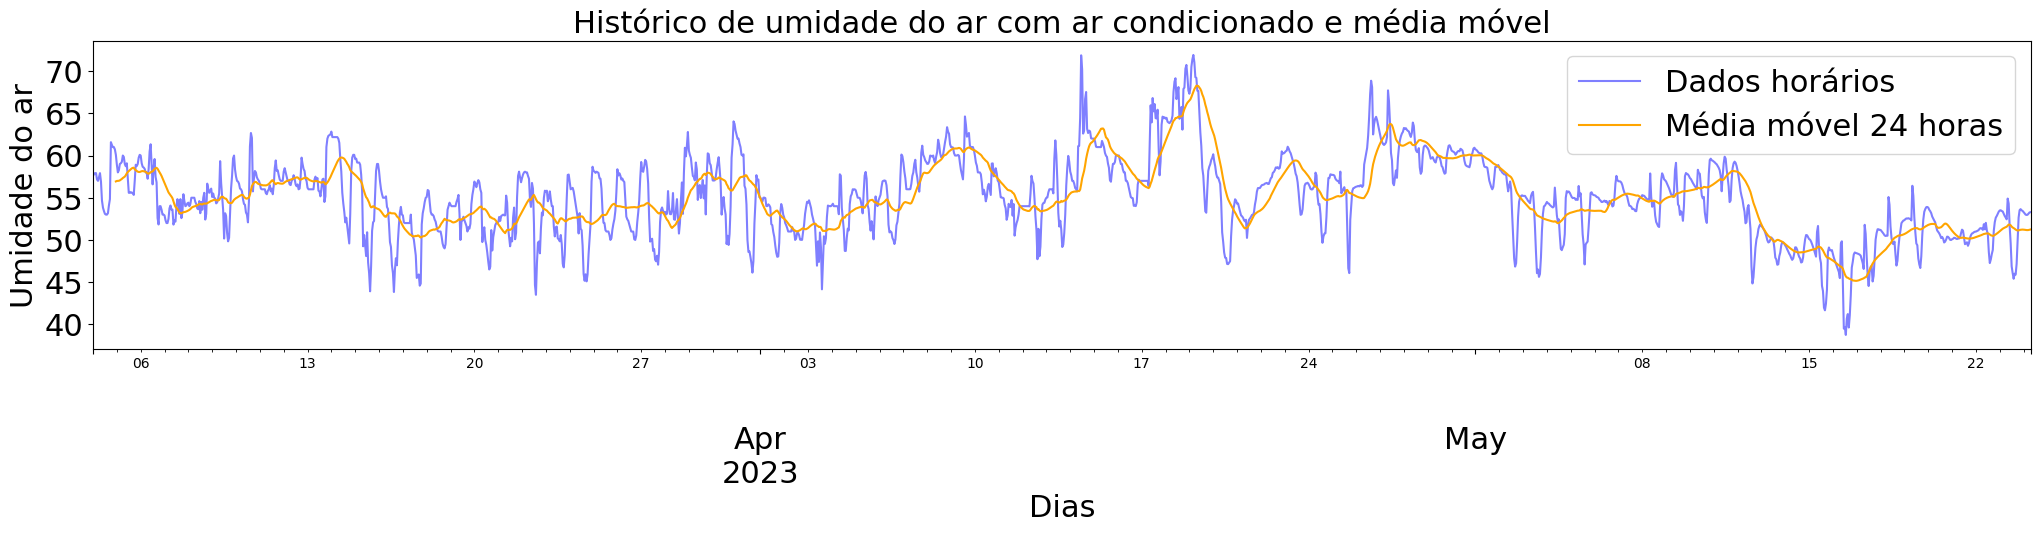

CPU times: user 1.1 s, sys: 113 ms, total: 1.21 s
Wall time: 1.12 s


In [65]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_comar.umid_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_comar['media_24_horas_umid_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Histórico de umidade do ar com ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

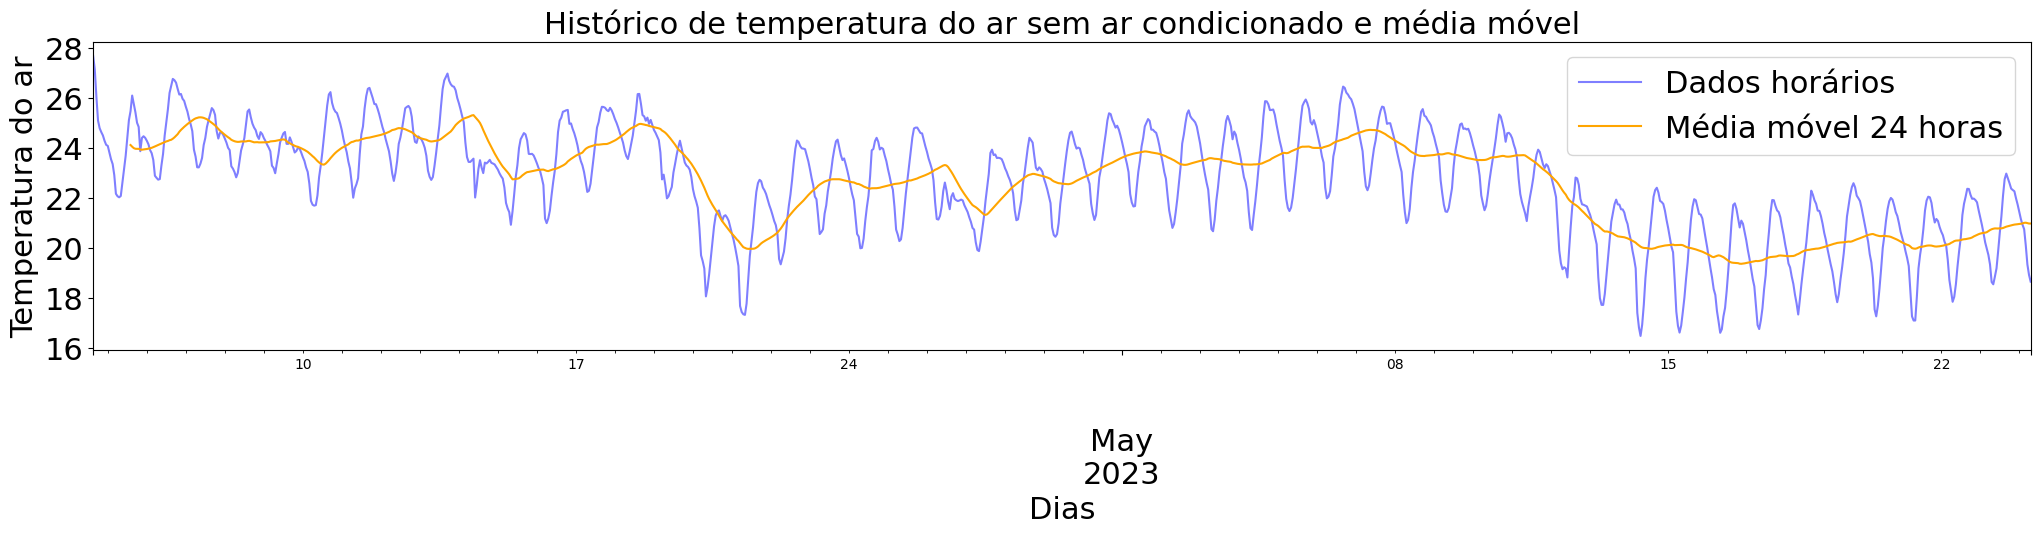

CPU times: user 1.07 s, sys: 109 ms, total: 1.18 s
Wall time: 1.09 s


In [66]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_semar.temp_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_semar['media_24_horas_temp_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Temperatura do ar',size=22)
plt.title('Histórico de temperatura do ar sem ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)

plt.savefig(f'assets/data_temperatura_ar_semar_conjunto_dados_agrupados_{minutos}_minutos_com_media_movel.png', facecolor='white', transparent=False)
plt.show()

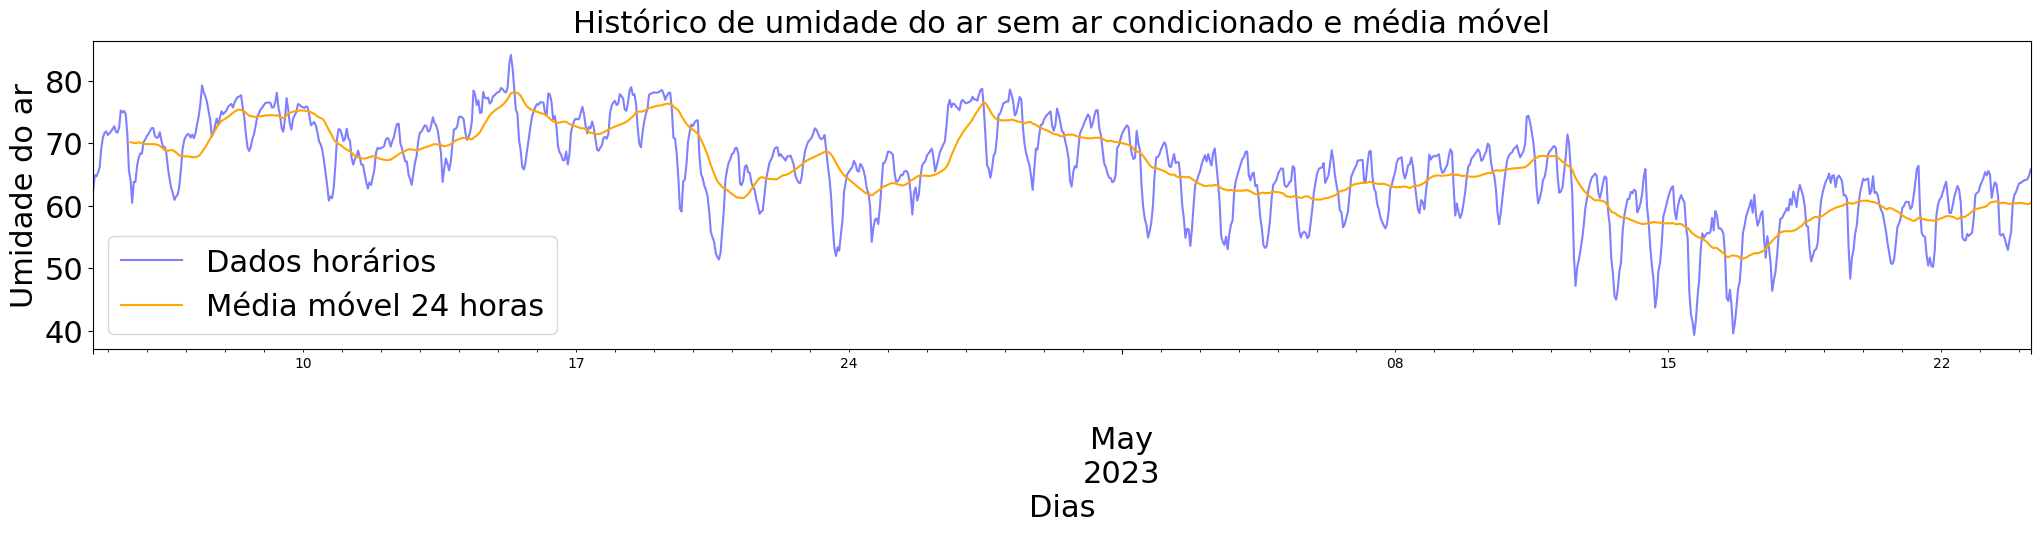

CPU times: user 744 ms, sys: 102 ms, total: 847 ms
Wall time: 773 ms


In [67]:
%%time
plt.figure(figsize=(25,4))
dados_agrupados_minutos_semar.umid_ar.plot(c='blue',alpha=0.5) # Dados reais
dados_agrupados_minutos_semar['media_24_horas_umid_ar'].plot(c='orange') # Dados da média móvel
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dias',size=22)
plt.ylabel('Umidade do ar',size=22)
plt.title('Histórico de umidade do ar sem ar condicionado e média móvel',size=22)
plt.legend(['Dados horários','Média móvel 24 horas'],fontsize=22)
plt.show()

# ARIMA


In [68]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.8 MB/s eta 0:00:00


In [69]:
%%time
from pmdarima.arima import auto_arima
modelo = auto_arima(dados_agrupados_minutos_comar.temp_ar)

CPU times: user 47.9 s, sys: 35.4 s, total: 1min 23s
Wall time: 1min 5s


In [70]:
modelo.predict_in_sample()

data
2023-03-04 00:00:00    0.00
2023-03-04 01:00:00   26.60
2023-03-04 02:00:00   26.59
2023-03-04 03:00:00   26.58
2023-03-04 04:00:00   26.51
                       ... 
2023-05-24 03:00:00   22.36
2023-05-24 04:00:00   22.31
2023-05-24 05:00:00   22.29
2023-05-24 06:00:00   22.23
2023-05-24 07:00:00   22.14
Freq: 60T, Name: predicted_mean, Length: 1952, dtype: float64

In [71]:
modelo.predict(12)

2023-05-24 08:00:00   22.21
2023-05-24 09:00:00   22.29
2023-05-24 10:00:00   22.36
2023-05-24 11:00:00   22.42
2023-05-24 12:00:00   22.47
2023-05-24 13:00:00   22.51
2023-05-24 14:00:00   22.55
2023-05-24 15:00:00   22.58
2023-05-24 16:00:00   22.60
2023-05-24 17:00:00   22.63
2023-05-24 18:00:00   22.65
2023-05-24 19:00:00   22.66
Freq: 60T, dtype: float64

In [72]:
%%time
modelo_semar = auto_arima(dados_agrupados_minutos_semar.temp_ar)

CPU times: user 1min 39s, sys: 1min 14s, total: 2min 54s
Wall time: 2min 3s


In [73]:
modelo_semar.predict_in_sample()

data
2023-04-04 15:00:00    0.00
2023-04-04 16:00:00   27.68
2023-04-04 17:00:00   26.72
2023-04-04 18:00:00   25.16
2023-04-04 19:00:00   24.35
                       ... 
2023-05-24 03:00:00   20.64
2023-05-24 04:00:00   20.52
2023-05-24 05:00:00   19.66
2023-05-24 06:00:00   18.92
2023-05-24 07:00:00   18.77
Freq: 60T, Name: predicted_mean, Length: 1193, dtype: float64

In [74]:
modelo_semar.predict(12)

2023-05-24 08:00:00   18.62
2023-05-24 09:00:00   18.79
2023-05-24 10:00:00   19.09
2023-05-24 11:00:00   19.51
2023-05-24 12:00:00   19.98
2023-05-24 13:00:00   20.50
2023-05-24 14:00:00   21.01
2023-05-24 15:00:00   21.48
2023-05-24 16:00:00   21.89
2023-05-24 17:00:00   22.20
2023-05-24 18:00:00   22.39
2023-05-24 19:00:00   22.45
Freq: 60T, dtype: float64

## Salvando o modelo com ar condicionado

In [75]:
with open('assets/model_comar','wb') as f:
        pickle.dump(modelo,f)

In [76]:
with open('assets/model_comar','rb') as f:
        modelo_salvo_comar = pickle.load(f)

In [77]:
ultimas_horas_com_ar = dados_agrupados_minutos_comar.temp_ar.tail(20)
index_str = ultimas_horas_com_ar.index.astype('str')
ultimas_horas_com_ar = ultimas_horas_com_ar.reindex(index_str).to_dict()
ultimas_horas_com_ar

pickle.dump(ultimas_horas_com_ar, open('assets/ultimas_horas_com_ar.p', 'wb'))

In [78]:
with open('assets/ultimas_horas_com_ar.p', 'rb') as f:
  ultimas_horas_com_ar_d = pickle.load(f)
ultimas_horas_com_ar_d

{'2023-05-23 12:00:00': 24.858333333333334,
 '2023-05-23 13:00:00': 25.275000000000002,
 '2023-05-23 14:00:00': 25.145454545454548,
 '2023-05-23 15:00:00': 25.0,
 '2023-05-23 16:00:00': 25.2,
 '2023-05-23 17:00:00': 24.727272727272727,
 '2023-05-23 18:00:00': 23.675,
 '2023-05-23 19:00:00': 23.150000000000002,
 '2023-05-23 20:00:00': 22.8,
 '2023-05-23 21:00:00': 22.641666666666666,
 '2023-05-23 22:00:00': 22.516666666666666,
 '2023-05-23 23:00:00': 22.483333333333334,
 '2023-05-24 00:00:00': 22.345454545454547,
 '2023-05-24 01:00:00': 22.3,
 '2023-05-24 02:00:00': 22.3,
 '2023-05-24 03:00:00': 22.266666666666666,
 '2023-05-24 04:00:00': 22.241666666666664,
 '2023-05-24 05:00:00': 22.183333333333334,
 '2023-05-24 06:00:00': 22.100000000000005,
 '2023-05-24 07:00:00': 22.130000000000003}

In [79]:
modelo_salvo_comar.predict(12)

2023-05-24 08:00:00   22.21
2023-05-24 09:00:00   22.29
2023-05-24 10:00:00   22.36
2023-05-24 11:00:00   22.42
2023-05-24 12:00:00   22.47
2023-05-24 13:00:00   22.51
2023-05-24 14:00:00   22.55
2023-05-24 15:00:00   22.58
2023-05-24 16:00:00   22.60
2023-05-24 17:00:00   22.63
2023-05-24 18:00:00   22.65
2023-05-24 19:00:00   22.66
Freq: 60T, dtype: float64

## Salvando o modelo sem ar condicionado

In [80]:
with open('assets/model_semar','wb') as f:
        pickle.dump(modelo_semar,f)

In [81]:
with open('assets/model_semar','rb') as f:
        modelo_salvo_semar = pickle.load(f)

In [82]:
ultimas_horas_sem_ar = dados_agrupados_minutos_semar.temp_ar.tail(20)
index_str = ultimas_horas_sem_ar.index.astype('str')
ultimas_horas_sem_ar = ultimas_horas_sem_ar.reindex(index_str).to_dict()

pickle.dump(ultimas_horas_sem_ar, open('assets/ultimas_horas_sem_ar.p', 'wb'))

In [83]:
with open('assets/ultimas_horas_sem_ar.p', 'rb') as f:
  ultimas_horas_sem_ar_d = pickle.load(f)
ultimas_horas_sem_ar_d


{'2023-05-23 12:00:00': 20.59166666666667,
 '2023-05-23 13:00:00': 21.25,
 '2023-05-23 14:00:00': 22.083333333333332,
 '2023-05-23 15:00:00': 22.741666666666664,
 '2023-05-23 16:00:00': 22.96666666666667,
 '2023-05-23 17:00:00': 22.775000000000002,
 '2023-05-23 18:00:00': 22.581818181818182,
 '2023-05-23 19:00:00': 22.366666666666664,
 '2023-05-23 20:00:00': 22.308333333333334,
 '2023-05-23 21:00:00': 22.258333333333336,
 '2023-05-23 22:00:00': 21.974999999999998,
 '2023-05-23 23:00:00': 21.724999999999998,
 '2023-05-24 00:00:00': 21.425,
 '2023-05-24 01:00:00': 21.14166666666667,
 '2023-05-24 02:00:00': 20.916666666666668,
 '2023-05-24 03:00:00': 20.741666666666667,
 '2023-05-24 04:00:00': 20.091666666666665,
 '2023-05-24 05:00:00': 19.325,
 '2023-05-24 06:00:00': 18.90909090909091,
 '2023-05-24 07:00:00': 18.64}

In [84]:
modelo_salvo_semar.predict(12)

2023-05-24 08:00:00   18.62
2023-05-24 09:00:00   18.79
2023-05-24 10:00:00   19.09
2023-05-24 11:00:00   19.51
2023-05-24 12:00:00   19.98
2023-05-24 13:00:00   20.50
2023-05-24 14:00:00   21.01
2023-05-24 15:00:00   21.48
2023-05-24 16:00:00   21.89
2023-05-24 17:00:00   22.20
2023-05-24 18:00:00   22.39
2023-05-24 19:00:00   22.45
Freq: 60T, dtype: float64

## Exportando imagens e modelo

In [85]:
shutil.make_archive('assets', 'zip', './', 'assets')

'/content/assets.zip'

In [86]:
dados_projeto_comar.to_csv('dados_projeto_comar')

In [87]:
dados_projeto_semar.to_csv('dados_projeto_semar')